# Insurance Database

## Configuration:
### Install Packages:

Ensure you have the library `sqlalchemy` installed in order to connect to the MySQL database.  Install these packages by uncommenting the code cell below:

In [1]:
# !pip install sqlalchemy

This Jupyter Notebook also requires the libraries `pandas` and `matplotlib` for importing and visualizing data.  Install these packages by uncommenting the code cell below:

In [2]:
# !pip install pandas
# !pip install matplotlib

### Load Functions and Packages:

In [43]:
import database_info #personal .py file containing database login info
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine

In [44]:
def import_data_from_database(table_name, engine):
    '''
    PURPOSE: Read in entire table from database to a pandas df

    PARAMETERS:
    -----------
        table_name : str
            Name of table in database
        engine : Engine object
            MySQL connection engine built using sqlalchemy.create_engine
    '''
    sql_query = "SELECT * FROM " + table_name
    df = pd.read_sql(sql_query, engine)
    return df

### Connect to SQL Database:

Now we can make our SQL connnection, first load in your `database_info.py` file:

In [45]:
import database_info

Now let's create our connection engine.  Make sure you've updated `database_info.py` with your connection information as well as ensuring the port number is correct:

In [46]:
from sqlalchemy import create_engine
engine = create_engine(database_info.connection_string)

## Import SQL tables using `pandas`:

The tables stored in our database are:
- `claim_fact`
- `dim_date`
- `dim_member`
- `dim_member_condition`
- `dim_place_of_service`
- `dim_procedure`
- `dim_provider`
- `dim_provider_specialty`
- `dim_reporting_category`

In [47]:
#read in tables from database
claims = import_data_from_database("claim_fact", engine)
members = import_data_from_database("dim_member", engine)
member_conditions = import_data_from_database("dim_member_condition", engine)
place_of_service = import_data_from_database("dim_place_of_service", engine)
procedure = import_data_from_database("dim_procedure", engine)
providers = import_data_from_database("dim_provider", engine)
provider_specialties = import_data_from_database("dim_provider_specialty", engine)
provider_categories = import_data_from_database("dim_reporting_category", engine)

In [48]:
claims.head()

,IDNO,ClaimID,ClaimLineNum,ClaimStatusCd,ClaimType,MemberID,ProviderID,posID,ServiceDate,LoadDate,Code_Type,Code_Value,AllowedCharges,PaidClaims,MemberPaid
0,1,1,1,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D9222,225.0,0.0,225.0
1,2,1,2,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D9223,413.0,0.0,413.0
2,3,2,2,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D7230,275.0,0.0,275.0
3,4,2,3,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D7230,275.0,37.0,238.0
4,5,2,4,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D7230,275.0,37.0,238.0


In [49]:
members.head()

,IDNO,memberID,Gender,dateOfBirth,firstname,lastname,member_street,member_city,member_County,member_state,member_zip,Product,Client_ID,StartDate,EndDate
0,1,1,M,1959-01-20,Liam,Aaron,1060 Blackjack Pine Street,Bulk Mail Center,Allegheny,PA,15095,PPO,A00124,2018-04-01,2020-12-31
1,2,2,M,1970-08-24,Noah,Archer,2383 Blister Fir Street,Warrendale,Allegheny,PA,15095,HMO,A00123,2021-09-01,2021-09-30
2,3,2,M,1970-08-24,Noah,Archer,2383 Blister Fir Street,Warrendale,Allegheny,PA,15095,HMO,A00123,2018-04-01,2021-07-31
3,4,3,M,1957-04-01,Elijah,Beck,1230 Bracted Balsam Fir Street,Bethel Park,Allegheny,PA,15102,PPO,A00124,2018-04-01,2018-07-31
4,5,4,M,1986-06-27,Lucas,Blixt,1755 Bristlecone Fir Street,Braddock,Allegheny,PA,15104,PPO,A00124,2018-04-01,2020-12-31


In [50]:
member_conditions.head()

,IDNO,memberID,DIABETES,CAD,CHF,HYPERTENSION,COPD,StartDate,EndDate
0,1,1,1,0,0,0,0,2020-08-01,2020-12-31
1,2,1,0,0,0,0,0,2018-04-01,2020-07-31
2,3,2,0,0,0,0,0,2019-01-01,2021-07-31
3,4,2,0,0,0,0,0,2021-09-01,2022-01-31
4,5,2,0,0,0,1,0,2018-04-01,2018-12-31


In [51]:
place_of_service.head()

,posID,pos_Desc,pos_category
0,1,Pharmacy,OF
1,2,Telehealth,OF
2,3,School,OF
3,4,Office,OF
4,5,Home,OF


In [52]:
procedure.head()

,IDNO,Code_Type,Code_Value,PROCEDURE_DESC,FACILITY_CD,PROF_CD
0,1,DRG,003,"ECMO or trach w MV 96+ hrs or PDX exc face, mo...",I12,I12
1,2,DRG,012,"Tracheostomy for Face, Mouth Neck Diagnoses o...",I12,I12
2,3,DRG,023,Craniotomy w Major Device Implant or Acute Com...,I12,I12
3,4,DRG,053,Spinal disorders injuries w/o CC/MCC,I11a,I11a
4,5,DRG,054,Nervous system neoplasms w MCC,I11a,I11a


In [53]:
providers.head()

,ProviderID,SpecialtyID,ProviderType,OrgName,FirstName,LastName,provider_street,provider_city,provider_county,provider_state,provider_zip
0,1,45,2,Not Applicable,Manuel,Estanislau,2533 Coyote Street,Levittown,Bucks,PA,19055
1,2,38,1,Thomas Marchese Medical Supplies,NA,NA,4207 Florida Slash Pine Street,George School,Bucks,PA,18940
2,3,65,2,Not Applicable,Edith,Evans,4080 Dalls Porpoise Street,Newportville,Bucks,PA,19056
3,4,8,2,Not Applicable,Anthony,Abbing,2844 Rock Vole Street,Caste Village,Allegheny,PA,15236
4,5,8,2,Not Applicable,Rossmore,Abbott,745 Rough-toothed Dolphin Street,Pittsburgh,Allegheny,PA,15236


In [54]:
provider_specialties.head()

,SpecialtyID,Specialty_Desc,SpecRup_Cd,SpecRup_DESC,SpecType
0,1,General practice,CS01,Family Practice / General Practice,PCP
1,2,General surgery,CS02,General Surgery,SPEC
2,3,Allergy / immunology,CS03,Allergy / Immunology,SPEC
3,4,Otolaryngology,CS04,Otolaryngology,SPEC
4,5,Anesthesiology,CS05,Anesthesiology,SPEC


In [55]:
provider_categories.head()

,RPT_CD,LVL_01,LVL_02,LVL_03
0,I11a,FIP,Medical,Other
1,I11b,FIP,Rehabilitation,Other
2,I12,FIP,Surgical,Other
3,I13a,FIP,Psychiatric,Hospital
4,I13b,FIP,Psychiatric,Residential


## EDA:

In [57]:
#convert columns
import pandas as pd

claims['ServiceDate'] = pd.to_datetime(claims['ServiceDate'])
claims['LoadDate'] = pd.to_datetime(claims['LoadDate'])

claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45423 entries, 0 to 45422
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   IDNO            45423 non-null  int64         
 1   ClaimID         45423 non-null  int64         
 2   ClaimLineNum    45423 non-null  int64         
 3   ClaimStatusCd   45423 non-null  object        
 4   ClaimType       45423 non-null  object        
 5   MemberID        45423 non-null  int64         
 6   ProviderID      45423 non-null  int64         
 7   posID           45423 non-null  int64         
 8   ServiceDate     45423 non-null  datetime64[ns]
 9   LoadDate        45423 non-null  datetime64[ns]
 10  Code_Type       45423 non-null  object        
 11  Code_Value      45423 non-null  object        
 12  AllowedCharges  45423 non-null  float64       
 13  PaidClaims      45423 non-null  float64       
 14  MemberPaid      45423 non-null  float64       
dtypes:

In [59]:
#convert members columns to date
members['dateOfBirth'] = pd.to_datetime(members['dateOfBirth'])
members['StartDate'] = pd.to_datetime(members['StartDate'])
members['EndDate'] = pd.to_datetime(members['EndDate'])
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   IDNO           840 non-null    int64         
 1   memberID       840 non-null    int64         
 2   Gender         840 non-null    object        
 3   dateOfBirth    840 non-null    datetime64[ns]
 4   firstname      840 non-null    object        
 5   lastname       840 non-null    object        
 6   member_street  840 non-null    object        
 7   member_city    840 non-null    object        
 8   member_County  840 non-null    object        
 9   member_state   840 non-null    object        
 10  member_zip     840 non-null    object        
 11  Product        840 non-null    object        
 12  Client_ID      840 non-null    object        
 13  StartDate      840 non-null    datetime64[ns]
 14  EndDate        840 non-null    datetime64[ns]
dtypes: datetime64[ns](3), i

In [60]:
#get number of males v females
member_sex_counts = members["Gender"].value_counts()
print(member_sex_counts, "\n")

#get proportions of males v females
member_sex_props = members["Gender"].value_counts(normalize=True)
print(member_sex_props)

M    498
F    342
Name: Gender, dtype: int64 

M    0.592857
F    0.407143
Name: Gender, dtype: float64


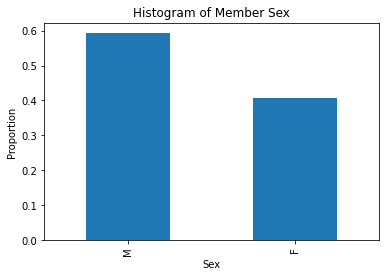

In [61]:
#plot data in matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

member_sex_props.plot(kind="bar")

ax.set_xlabel("Sex")
ax.set_ylabel("Proportion")
ax.set_title("Histogram of Member Sex")
plt.show()

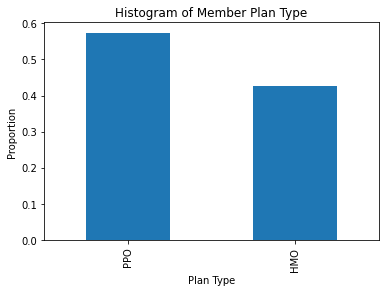

In [64]:
fig, ax = plt.subplots()

members_type_of_policy = members["Product"].value_counts(normalize=True)
members_type_of_policy.plot(kind="bar")

ax.set_xlabel("Plan Type")
ax.set_ylabel("Proportion")
ax.set_title("Histogram of Member Plan Type")

plt.show()

## Time Series Analysis:

Let's try to visualize the number of claims, and charges based on `ServiceDate`.

In [65]:
claims.head()

,IDNO,ClaimID,ClaimLineNum,ClaimStatusCd,ClaimType,MemberID,ProviderID,posID,ServiceDate,LoadDate,Code_Type,Code_Value,AllowedCharges,PaidClaims,MemberPaid
0,1,1,1,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D9222,225.0,0.0,225.0
1,2,1,2,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D9223,413.0,0.0,413.0
2,3,2,2,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D7230,275.0,0.0,275.0
3,4,2,3,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D7230,275.0,37.0,238.0
4,5,2,4,A,P,251,1348,4,2019-01-18,2019-03-02,HCPC,D7230,275.0,37.0,238.0


In [82]:
#get only service date and charges
claims_ts = claims.loc[:, ["ServiceDate", "AllowedCharges", "PaidClaims", "MemberPaid"]]
claims_ts.head()

,ServiceDate,AllowedCharges,PaidClaims,MemberPaid
0,2019-01-18,225.0,0.0,225.0
1,2019-01-18,413.0,0.0,413.0
2,2019-01-18,275.0,0.0,275.0
3,2019-01-18,275.0,37.0,238.0
4,2019-01-18,275.0,37.0,238.0


In [90]:
daily_claims = claims_ts.groupby("ServiceDate").sum()
pd.to_csv("")
daily_claims.head()

,AllowedCharges,PaidClaims,MemberPaid
ServiceDate,,,
2018-04-02,4308.65,2891.09,1417.56
2018-04-03,4748.53,4342.01,406.52
2018-04-04,24545.89,21086.49,3459.40
2018-04-05,16562.68,15097.53,1465.15
2018-04-06,2937.56,1688.76,1248.80


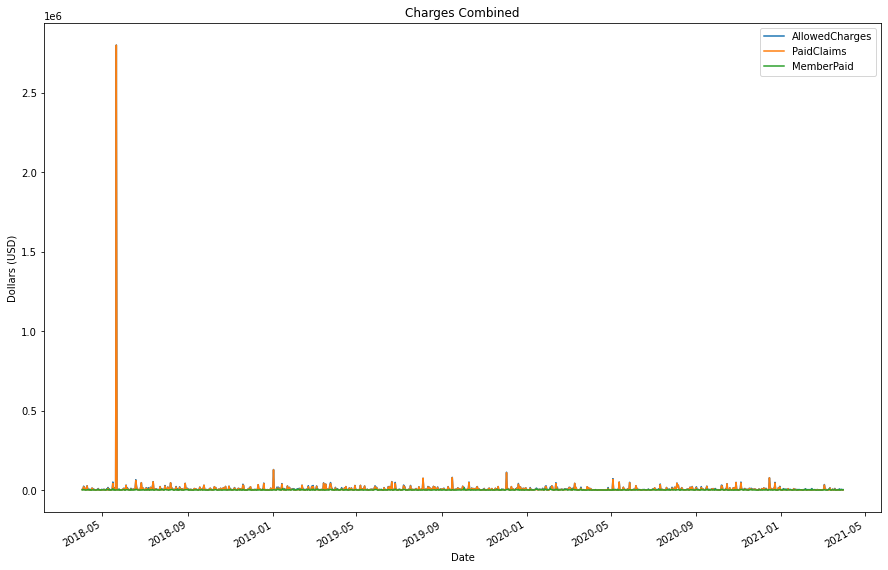

In [92]:
daily_claims.plot()

#customize appearance
plt.xlabel("Date")
plt.title("Charges Combined")
plt.ylabel("Dollars (USD)")
plt.gcf().set_size_inches(15, 10)
plt.show()

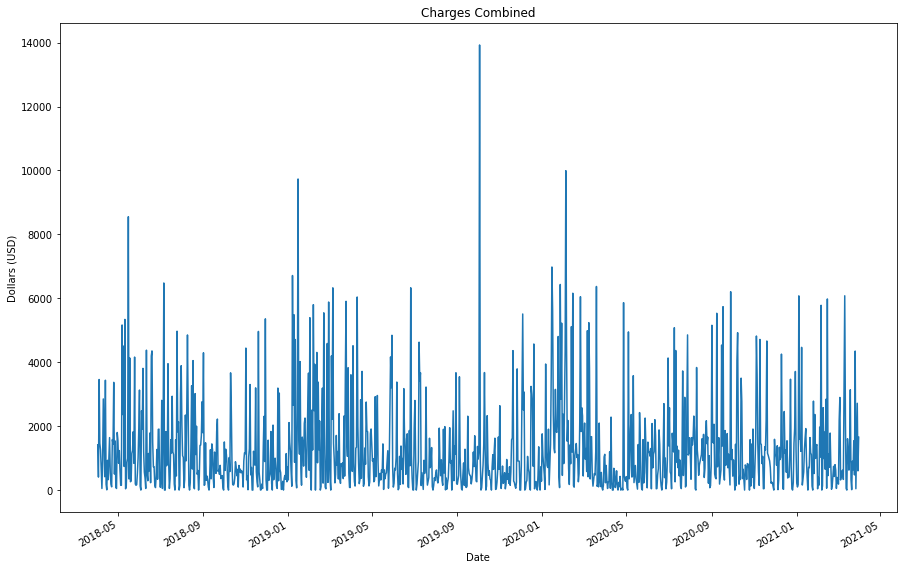

In [93]:
daily_claims["MemberPaid"].plot()

#customize appearance
plt.xlabel("Date")
plt.title("Charges Combined")
plt.ylabel("Dollars (USD)")
plt.gcf().set_size_inches(15, 10)
plt.show()

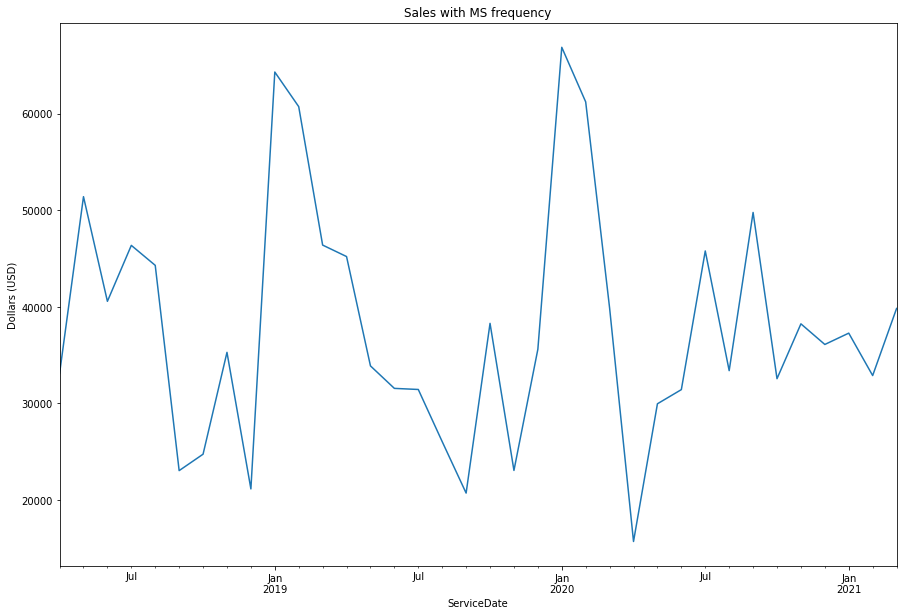

In [95]:
monthly_claims = daily_claims.groupby(pd.Grouper(freq="MS")).sum()
monthly_claims["MemberPaid"].plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales with MS frequency")
plt.ylabel("Dollars (USD)")
plt.show()